<h1 style="text-align: center;">Python Notebook for Running the Computational Module of HYDRUS(2D/3D)</h1>
<hr>

<p style="font-size: 16px; line-height: 1.5;">
  <strong>Purpose:</strong> A <strong>Tluliot</strong> Jupyter Notebook for Running the Computational Module of HYDRUS(2D/3D) in Python <br>
  <strong>Advisor:</strong> Prof. Naftali Lazarovitch <br>
  <strong>Advisor:</strong> Dr. Iael Raij-Hoffman <br>
  <strong>Author:</strong> Onan Agaba <br>
  <strong>Created:</strong> July 04, 2024 <br>
  <strong>Last Modified:</strong> May 25, 2025
</p>

<p style="font-size: 16px; line-height: 1.5;">
  <strong>Aim:</strong> This code does: <br>
  &nbsp;&nbsp;&nbsp;&nbsp;<strong>Part 1:</strong> Reads and Modifies input (.IN) files <br>
  &nbsp;&nbsp;&nbsp;&nbsp;<strong>Part 2:</strong> Runs HYDRUS (2D/3D) iteratively <br>
  &nbsp;&nbsp;&nbsp;&nbsp;<strong>Part 3:</strong> Calculates Objective Functions: NSE, RMSE, R² <br>
  &nbsp;&nbsp;&nbsp;&nbsp;<strong>Part 4:</strong> Tests Global Sensitivity Analysis (GSA) using SOBOL'S approach <br>
  &nbsp;&nbsp;&nbsp;&nbsp;<strong>Part 5:</strong> Plots Sensitivity using Response Surface and other Charts  <br>
 






  

  
</p>


In [ ]:
%%writefile HYDRUS_RUNS.py


import os                                          
import subprocess                                  
import numpy as np                                 
import matplotlib.pyplot as plt                     
import pandas as pd
import shutil
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  


# Define HYDRUS_RUNS class
class HYDRUS_RUNS:
    

    # Constructor __init__ to initiate the class HYDRUS_RUNS
    def __init__(self, ProjectFileLocation, pjrt):
        '''
        Initializes an instance of HYDRUS_RUNS with project directory and name.
        Parameters
               self: reference to the current instance/object of the class
               ProjectFileLocation (str): Path to the working folder where our input (.IN) files are located (an argument)
               pjrt (str): Identifier for our HYDRUS (2D/3D) project. (an argument)
        '''
        self.directory = ProjectFileLocation
        self.pjrt = pjrt
       


    # Write into the Selector.IN file
    def modify_selector_in(self, modifications):
        '''
        Modifies the SELECTOR.IN file based on specified modifications.
        '''
        selector_in_path = os.path.join(self.directory, "SELECTOR.IN")
        
        if not os.path.isfile(selector_in_path):
            print(f"Error: SELECTOR.IN file not found at {selector_in_path}")
            return
        
        with open(selector_in_path, 'r') as file:
            lines = file.readlines()
        
        for mod in modifications:
            line_value, col_value, new_value = mod['value_line'], mod['value_col'], str(mod['new_value'])
            
            if line_value - 1 >= len(lines):
                print(f"Error: line_value {line_value} is out of range.")
                continue
            
            line_values = lines[line_value - 1].split()
            
            if col_value - 1 >= len(line_values):
                print(f"Error: col_value {col_value} is out of range.")
                continue
            
            line_values[col_value - 1] = new_value
            lines[line_value - 1] = ' '.join(line_values) + '\n'
        
        with open(selector_in_path, 'w') as file:
            file.writelines(lines)
        
        print(f"SELECTOR.IN file modified with {modifications}")




    # Run a HYDRUS simulation
    def run_hydrus(self):
        '''
        Executes HYDRUS simulation for the specified project directory
        '''
        hydrus_exe = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis\H2D_Calc64.exe"
        args = [hydrus_exe, self.directory]
        
        try:
            subprocess.run(args, check=True)
            print("HYDRUS simulation completed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"HYDRUS simulation failed with return code {e.returncode}.")




    # Read output and input files (Cum_Q.out, v_Mean.out, Balance.out, and Fit.in)
    # Read Cum_Q.out file
    def read_cum_q_output(self, file_name="Cum_Q.out"):
        '''
        Reads the Cum_Q.out file and extracts Time, CumQAP, CumQRP, CumQA, CumQR and CumQ3 columns.
        '''
        file_path = os.path.join(self.directory, file_name)
        
        # Check if file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
        
        header_rows = 10
        try:
            data = pd.read_csv(file_path, sep=r'\s+', skiprows=header_rows)  
            time = pd.to_numeric(data.iloc[:, 0], errors='coerce')
            cum_qap = pd.to_numeric(data.iloc[:, 1], errors='coerce')
            cum_qrp = pd.to_numeric(data.iloc[:, 2], errors='coerce')
            cum_qa = pd.to_numeric(data.iloc[:, 3], errors='coerce')
            cum_qr = pd.to_numeric(data.iloc[:, 4], errors='coerce')
            cum_q3 = pd.to_numeric(data.iloc[:, 5], errors='coerce')
            valid_rows = time.notna() & cum_qap.notna() & cum_qrp.notna() & cum_qa.notna() & cum_qr.notna() & cum_q3.notna() 
            cum_q_df = pd.DataFrame({'Time': time[valid_rows], 'CumQAP': cum_qap[valid_rows],'CumQRP': cum_qrp[valid_rows], 'CumQA': cum_qa[valid_rows],'CumQR': cum_qr[valid_rows], 'CumQ3': cum_q3[valid_rows]})
            return cum_q_df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None





    # Read v_Mean.out file
    def read_v_mean_output(self, file_name="v_Mean.out"):
        '''
        Reads the v_Mean.out file and extracts Time, rAtm, rRoot, vAtm, vRoot, vKode3 columns.
        '''
        file_path = os.path.join(self.directory, file_name)
        
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
        
        header_rows = 10
        try:
            data = pd.read_csv(file_path, sep=r'\s+', skiprows=header_rows)  
            time = pd.to_numeric(data.iloc[:, 0], errors='coerce')
            r_atm = pd.to_numeric(data.iloc[:, 1], errors='coerce')
            r_root = pd.to_numeric(data.iloc[:, 2], errors='coerce')
            v_atm = pd.to_numeric(data.iloc[:, 3], errors='coerce')
            v_root = pd.to_numeric(data.iloc[:, 4], errors='coerce')
            v_kode3 = pd.to_numeric(data.iloc[:, 5], errors='coerce')
            valid_rows = time.notna() & r_atm.notna() & r_root.notna() & v_atm.notna() & v_root.notna() & v_kode3.notna() 
            v_mean_df = pd.DataFrame({'Time': time[valid_rows], 'rAtm': r_atm[valid_rows],'rRoot': r_root[valid_rows], 'vAtm': v_atm[valid_rows],'vRoot': v_root[valid_rows], 'vKode3': v_kode3[valid_rows]})
            return v_mean_df
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None




    # Read Balance.out file
    def read_balance_output(self, file_name = "Balance.out"):
        '''
        Reads the Balance.out file and extracts Water Balance Ratio, Concentration Balance Ratio, Calculation Time.
        '''
        file_path = os.path.join(self.directory, file_name)
        
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
        
        try:
            # Read the file line by line
            with open(file_path, 'r') as file:
                lines = file.readlines()
    
            # Extract information based on specific row and column indices
            water_balance_label = lines[737].split()[0]  # Row 738 (0-indexed), Column 1
            water_balance_value = float(lines[737].split()[2])  # Row 738, Column 3

            concentration_balance_label = lines[738].split()[0]  # Row 739, Column 1
            concentration_balance_value = float(lines[738].split()[3])  # Row 739, Column 4

            calculation_label = lines[743].split()[0]  # Row 744, Column 1
            calculation_value = float(lines[744].split()[3])  # Row 744, Column 4

          # Create a balance info dataframe with the extracted values
            balance_info = {
                "Label": [water_balance_label, concentration_balance_label, calculation_label],
                "Value": [water_balance_value, concentration_balance_value, calculation_value]
            }
            balance_df = pd.DataFrame(balance_info)

            return balance_df

        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None
         



    # Read Fit.in file
    def read_fit_input(self, file_name="Fit.in"):
        '''
        Reads the Fit.in file and extracts data starting from row 21.
        '''
        file_path = os.path.join(self.directory, file_name)
    
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
    
        try:
            # Read the file into a list of lines
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Drop the last line (metadata)
            lines = lines[:-1]
            
            # Write the cleaned lines to a temporary file
            temp_file_path = file_path + '.tmp'
            with open(temp_file_path, 'w') as temp_file:
                temp_file.writelines(lines)
            
            # Read the temporary file and skip the first 20 rows (metadata)
            data = pd.read_csv(temp_file_path, sep=r'\s+', skiprows=19)
    
            # Set the headers from row 21
            data.columns = data.iloc[0]
            data = data[1:]
    
            # Drop the first column (empty)
            data = data.iloc[:, 0:]
    
            # Drop the last column (has NAN values)
            data = data.iloc[:, :-1]

            # Reset the index
            data.reset_index(drop=True, inplace=True)
    
            # Remove the temporary file
            os.remove(temp_file_path)
            
            # Rename the columns
            data.columns = ['Time', 'Quantity', 'Type', 'Position', 'Weight']
    
            return data
    
        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None      



    # Read ObsNod.out file  
    def read_obsnod_output(self, file_name="ObsNod.out"):
        '''
        Reads the ObsNod.out file and extracts observation data.
        '''
        file_path = os.path.join(self.directory, file_name)
        
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
        
        try:
            # Read the file line by line
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Extract the header from the sixth line
            header_line = lines[5].strip().split()
            headers = ['Time']
            for i in range(1, len(header_line), 5):
                node_index = (i // 5) + 1
                headers.extend([
                    f"hNew_Node{node_index}", 
                    f"theta_Node{node_index}", 
                    f"Temp_Node{node_index}", 
                    f"Conc_Node{node_index}", 
                    f"Sorb_Node{node_index}"
                ])
            
            # Read the data starting from the seventh line
            data_lines = lines[7:]   # Model results start from Time = 0 not 0.5
            data = []
            for line in data_lines:
                data.append(line.strip().split())

            # Drop the last line/row
            data = data[:-1]    
            
            # Convert the data into a DataFrame
            df = pd.DataFrame(data, columns=headers)
            
            # Convert numeric columns to appropriate data types
            df = df.apply(pd.to_numeric, errors='coerce')
            
            return df

        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None



# Read ObsNod.out file from the Synthetic Data folder
    def read_obsnod_synthetic(self, file_name="ObsNod.out"):
        '''
        Reads the ObsNod.out file from the Synthetic Data folder and extracts observation data.
        '''
        synthetic_data_folder = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis\Synthetic Data\HYD5_1. Tree 1 -  Soil Mound (100% Compost) - Inverse"
        file_path = os.path.join(synthetic_data_folder, file_name)
        
        # Check if the file exists
        if not os.path.isfile(file_path):
            print(f"Error: {file_name} not found at {file_path}")
            return None
        
        try:
            # Read the file line by line
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Extract the header from the sixth line
            header_line = lines[5].strip().split()
            headers = ['Time']
            for i in range(1, len(header_line), 5):
                node_index = (i // 5) + 1
                headers.extend([
                    f"hNew_Node{node_index}", 
                    f"theta_Node{node_index}", 
                    f"Temp_Node{node_index}", 
                    f"Conc_Node{node_index}", 
                    f"Sorb_Node{node_index}"
                ])
            
            # Read the data starting from the seventh line
            data_lines = lines[7:]   # Model results start from Time = 0 not 0.5
            data = []
            for line in data_lines:
                data.append(line.strip().split())

            # Drop the last line/row
            data = data[:-1]    
            
            # Convert the data into a DataFrame
            df = pd.DataFrame(data, columns=headers)
            
            # Convert numeric columns to appropriate data types
            df = df.apply(pd.to_numeric, errors='coerce')
            
            return df

        except Exception as e:
            print(f"Error reading {file_name}: {e}")
            return None


   
    # Calculate the Objective functions / Goodness of Fit / Optimization Metrics (R², RMSE, NSE) 
    def calculate_gof(self, observed, simulated):
        '''
        Calculates the Coefficient od Determination (R²), Root Mean Square Error (RMSE) and Nash-Sutcliffe Efficiency (NSE) 
        between observed and simulated data.
        '''
        # Convert data to numeric and handle NaN/missing values
        observed = pd.to_numeric(observed, errors='coerce').to_numpy()
        simulated = pd.to_numeric(simulated, errors='coerce').to_numpy()
        valid_indices = ~np.isnan(observed) & ~np.isnan(simulated)
        observed = observed[valid_indices]
        simulated = simulated[valid_indices]
        
        # Check for valid data points
        if len(observed) == 0 or len(simulated) == 0:
            print(f"Error: No valid data points found for GOF calculation.")
            return None, None, None
        
        # Mean of observed and simulated values
        observed_mean = np.mean(observed)
        simulated_mean = np.mean(simulated)

        # Calculate residuals
        residuals = observed - simulated

        # Coefficient of Determination (R²)
        numerator_r2 = np.sum((observed - observed_mean) * (simulated - simulated_mean))**2
        denominator_r2 = (np.sum((observed - observed_mean)**2) * np.sum((simulated - simulated_mean)**2))
        r2 = numerator_r2 / denominator_r2 if denominator_r2 != 0 else None
        
        # Calculate Root Mean Square Error (RMSE)
        rmse = np.sqrt(np.mean(residuals**2))

        # Calculate Nash-Sutcliffe Efficiency (NSE)
        numerator_nse = np.sum(residuals**2)
        denominator_nse = np.sum((observed - observed_mean)**2)
        nse = 1 - (numerator_nse / denominator_nse) if denominator_nse != 0 else None

        return r2, rmse, nse  



# Directory to working folder
pjrt_location = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis\HYD5_1. Tree 1 -  Soil Mound (100% Compost) - Inverse"
working_folder = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis"
pjrt_name = "Tluliot HYDRUS(2D/3D) Water Flow and Solute Transport Modeling"
hydrus = HYDRUS_RUNS(pjrt_location, pjrt_name)   



# File Handling - Writing the Level_01 file
# Define the path of the 'level_01' file inside the working folder
original_file_path = os.path.join(working_folder, "level_01")
# Check if the file exists, if not, create it
if not os.path.exists(original_file_path):
    with open(original_file_path, "w") as file:
        file.write(pjrt_location)
    print(f"The file 'level_01' has been created with the project directory path.")
else:
    print(f"The file 'level_01' already exists.")
# Define the new file path with .dir extension
new_file_path = os.path.splitext(original_file_path)[0] + ".dir"
# Check if the new file with .dir extension already exists, if so, delete it
if os.path.exists(new_file_path):
    os.remove(new_file_path)  # Remove the existing file to avoid FileExistsError
    print(f"An existing file '{new_file_path}' was found and deleted.")
# Rename the file to have the .dir extension
os.rename(original_file_path, new_file_path)
print(f"The file has been renamed to: {new_file_path}")


Overwriting HYDRUS_RUNS.py


# Integrating Global Sensitivity Analysis (GSA) with HYDRUS Simulations

This section integrates GSA with HYDRUS by automating parameter sampling, running simulations, and analyzing sensitivity using Sobol's method.

In [7]:
# Install SALib if not already installed
#!pip install SALib

In [ ]:
# Libraries
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import os
import pandas as pd
from HYDRUS_RUNS import HYDRUS_RUNS

In [ ]:
# Define the HYDRUS model function
def hydrus_model_function(params):
    # Ensure the hydrus object is initialized
    global hydrus
    if 'hydrus' not in globals():
        project_dir = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis\HYD5_1. Tree 1 -  Soil Mound (100% Compost) - Inverse"
        project_name = 'HYDRUS_GSA'
        hydrus = HYDRUS_RUNS(project_dir, project_name)

    # Unpack parameters
    thr, ths, alfa, n, Ks = params

    # Modify SELECTOR.IN file
    """
    Note: Modifications for Layers
         - Layer 1 - Soil Mound (100% Compost)- "value_line": 25, "value_col": 1-5 represents layer 1 parameters
         - Layer 2 - Soil Mound (100% Compost)- "value_line": 26, "value_col": 1-5 represents layer 2 parameters
    """

    modifications = [
        {'value_line': 25, 'value_col': 1, 'new_value': thr},
        {'value_line': 25, 'value_col': 2, 'new_value': ths},
        {'value_line': 25, 'value_col': 3, 'new_value': alfa},
        {'value_line': 25, 'value_col': 4, 'new_value': n},
        {'value_line': 25, 'value_col': 5, 'new_value': Ks}
    ]
    hydrus.modify_selector_in(modifications)
   
    # Run HYDRUS simulation
    hydrus.run_hydrus()

    # Read output (e.g., RMSE from Fit.in or other metrics)
    # Read observed data from synthetic ObsNod.out
    obsnod_synthetic_data = hydrus.read_obsnod_synthetic()
    # Read simulated data from ObsNod.out
    obsnod_simulated_data = hydrus.read_obsnod_output()

    if obsnod_synthetic_data is not None and obsnod_simulated_data is not None:
        observed_values = obsnod_synthetic_data[['theta_Node1', 'theta_Node6']]  # Example: using 'theta_Node1' and 'theta_Node6' as observed values
        simulated_values = obsnod_simulated_data[['theta_Node1', 'theta_Node6']]  # Example: using 'theta_Node1' and 'theta_Node6' as simulated values
        rmse = np.sqrt(np.mean((observed_values - simulated_values)**2))
        return rmse
    else:
        return None


In [10]:
# Define the problem
problem = {
    'num_vars': 5,
    'names': ['thr', 'ths', 'alfa', 'n', 'Ks'],
    'bounds': [[0.1, 0.4], [0.3, 0.8], [0.01, 0.1], [1.5, 2.5], [50, 200]]
}

In [ ]:
# Generate parameter samples
from SALib.sample import saltelli
param_values = saltelli.sample(problem, 100)

# Initialize HYDRUS instance
project_dir = r"C:\HYDRUS Batch - Tluliot\Projects\20250404_Sensitivity_Analysis\HYD5_1. Tree 1 -  Soil Mound (100% Compost) - Inverse"
project_name = 'HYDRUS_GSA'
hydrus = HYDRUS_RUNS(project_dir, project_name)

# Create or open the results CSV file
results_file = 'simulation_results_4b.csv'
if not os.path.exists(results_file):
    # Create the file and write the header if it doesn't exist
    with open(results_file, 'w') as file:
        file.write('thr,ths,alfa,n,Ks,Time,Observed,Simulated,RMSE\n')

# Initialize an empty list to store results for Sobol analysis
results = []

# Run HYDRUS simulations for each parameter set
for params in param_values:
    thr, ths, alfa, n, Ks = params
    rmse = hydrus_model_function(params)  # Run the simulation

    # Read observed and simulated data
    obsnod_synthetic_data = hydrus.read_obsnod_synthetic()
    obsnod_simulated_data = hydrus.read_obsnod_output()

    if obsnod_synthetic_data is not None and obsnod_simulated_data is not None:
        # Extract observed and simulated values (example: 'hNew_Node1')
        observed_values = obsnod_synthetic_data[['theta_Node1', 'theta_Node6']].values.flatten()
        simulated_values = obsnod_simulated_data[['theta_Node1', 'theta_Node6']].values.flatten()

        # Append results to the CSV file and the list
        with open(results_file, 'a') as file:
            for time, observed_node1, simulated_node1, observed_node6, simulated_node6 in zip(
                obsnod_synthetic_data['Time'], 
                obsnod_synthetic_data['theta_Node1'], 
                obsnod_simulated_data['theta_Node1'], 
                obsnod_synthetic_data['theta_Node6'], 
                obsnod_simulated_data['theta_Node6']
            ):
                file.write(f"{thr},{ths},{alfa},{n},{Ks},{time},{observed_node1:.6f},{simulated_node1:.6f},{observed_node6:.6f},{simulated_node6:.6f},{rmse:.6f}\n")
        results.append(rmse)  # Store RMSE for Sobol analysis

print(f"All simulation results have been saved incrementally to '{results_file}'")


SELECTOR.IN file modified with [{'value_line': 25, 'value_col': 1, 'new_value': np.float64(0.103515625)}, {'value_line': 25, 'value_col': 2, 'new_value': np.float64(0.466015625)}, {'value_line': 25, 'value_col': 3, 'new_value': np.float64(0.0363671875)}, {'value_line': 25, 'value_col': 4, 'new_value': np.float64(1.69140625)}, {'value_line': 25, 'value_col': 5, 'new_value': np.float64(185.3515625)}]


C:\Users\Hydrus\AppData\Local\Temp\ipykernel_21432\2148548797.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 100)
c:\HYDRUS Batch - Tluliot\venv\Lib\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


HYDRUS simulation completed successfully.
SELECTOR.IN file modified with [{'value_line': 25, 'value_col': 1, 'new_value': np.float64(0.302734375)}, {'value_line': 25, 'value_col': 2, 'new_value': np.float64(0.466015625)}, {'value_line': 25, 'value_col': 3, 'new_value': np.float64(0.0363671875)}, {'value_line': 25, 'value_col': 4, 'new_value': np.float64(1.69140625)}, {'value_line': 25, 'value_col': 5, 'new_value': np.float64(185.3515625)}]
HYDRUS simulation completed successfully.
SELECTOR.IN file modified with [{'value_line': 25, 'value_col': 1, 'new_value': np.float64(0.103515625)}, {'value_line': 25, 'value_col': 2, 'new_value': np.float64(0.731640625)}, {'value_line': 25, 'value_col': 3, 'new_value': np.float64(0.0363671875)}, {'value_line': 25, 'value_col': 4, 'new_value': np.float64(1.69140625)}, {'value_line': 25, 'value_col': 5, 'new_value': np.float64(185.3515625)}]
HYDRUS simulation completed successfully.
SELECTOR.IN file modified with [{'value_line': 25, 'value_col': 1, 'ne

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

# Convert results to a NumPy array if not already
results_array = np.array(results)

# Perform Sobol sensitivity analysis
sobol_indices = sobol.analyze(problem, results_array)

# Print Sobol indices
print('First-order indices:', sobol_indices['S1'])
print('Total-order indices:', sobol_indices['ST'])

In [ ]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np

# Define the problem
problem = {
    'num_vars': 5,
    'names': ['thr', 'ths', 'alfa', 'n', 'Ks'],
    'bounds': [[0.1, 0.4], [0.3, 0.8], [0.01, 0.1], [1.5, 2.5], [50, 200]]
}

# Generate parameter samples with calc_second_order=True
param_values = saltelli.sample(problem, 100, calc_second_order=True)

# Simulate results (replace this with actual simulation code)
results = np.random.rand(len(param_values))  # Example: Replace with actual results
results_array = np.array(results)

# Ensure no NaN values
results_array = results_array[~np.isnan(results_array)]

# Verify the number of samples
expected_samples = (2 * problem['num_vars'] + 2) * 100  # Base sample size = 10
if len(results_array) != expected_samples:
    print(f"Error: Expected {expected_samples} samples, but got {len(results_array)}.")
else:
    # Perform Sobol sensitivity analysis
    sobol_indices = sobol.analyze(problem, results_array, calc_second_order=True)

    # Print Sobol indices
    print("First-order indices:", sobol_indices['S1'])
    print("Total-order indices:", sobol_indices['ST'])

First-order indices: [0.01266146 0.22331742 0.19112687 0.18472451 0.0638641 ]
Total-order indices: [1.04284875 1.23020068 0.77776778 1.23596659 0.90873263]


C:\Users\Hydrus\AppData\Local\Temp\ipykernel_27204\1806104828.py:13: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 40, calc_second_order=True)


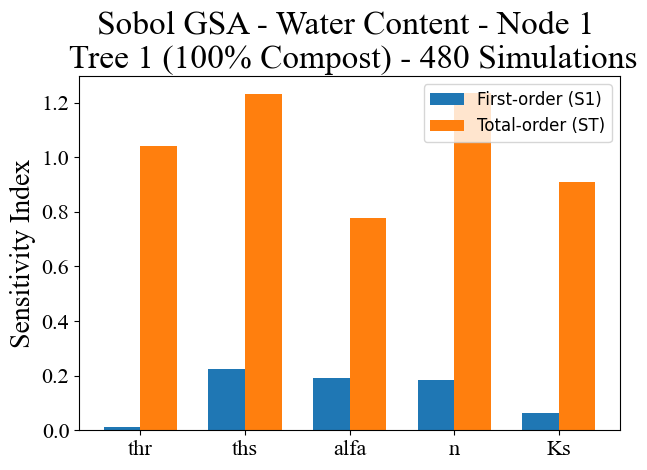

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example parameter names
parameter_names = ['thr', 'ths', 'alfa', 'n', 'Ks']

# Sobol indices (replace with your actual results)
S1 = sobol_indices['S1']
ST = sobol_indices['ST']

# Plot
x = np.arange(len(parameter_names))
width = 0.35
plt.bar(x - width/2, S1, width, label='First-order (S1)')
plt.bar(x + width/2, ST, width, label='Total-order (ST)')

plt.xticks(x, parameter_names, fontsize=16, fontname='Times New Roman')
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.ylabel('Sensitivity Index', fontsize=20, fontname='Times New Roman')
plt.title('Sobol GSA - Water Content - Node 1 \n Tree 1 (100% Compost) - 480 Simulations', fontsize=24, fontname='Times New Roman')
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

# Save the plot as a PNG file
plt.savefig('sobol_sensitivity_analysis_40samples.png')

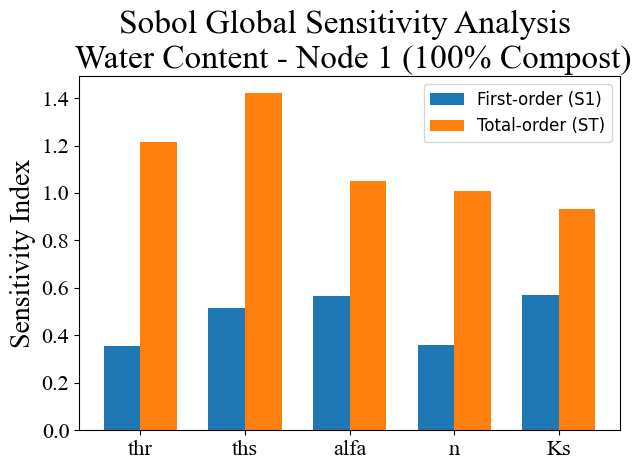

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example parameter names
parameter_names = ['thr', 'ths', 'alfa', 'n', 'Ks']

# Sobol indices (replace with your actual results)
S1 = sobol_indices['S1']
ST = sobol_indices['ST']

# Plot
x = np.arange(len(parameter_names))
width = 0.35
plt.bar(x - width/2, S1, width, label='First-order (S1)')
plt.bar(x + width/2, ST, width, label='Total-order (ST)')

plt.xticks(x, parameter_names, fontsize=16, fontname='Times New Roman')
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.ylabel('Sensitivity Index', fontsize=20, fontname='Times New Roman')
plt.title('Sobol Global Sensitivity Analysis \n Water Content - Node 1 (100% Compost)', fontsize=24, fontname='Times New Roman')
plt.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from SALib.analyze import sobol
import pandas as pd

# Perform Sobol sensitivity analysis
sobol_indices = sobol.analyze(problem, results_array, calc_second_order=True, conf_level=0.95, print_to_console=False)

# Extract Sobol indices and confidence intervals
S1 = sobol_indices['S1']
S1_conf = sobol_indices['S1_conf']
ST = sobol_indices['ST']
ST_conf = sobol_indices['ST_conf']

# Create a DataFrame for better visualization
parameter_names = problem['names']
sobol_results = pd.DataFrame({
    'Parameter': parameter_names,
    'S1': S1,
    'S1 (BCI)': S1_conf,
    'ST': ST,
    'ST (BCI)': ST_conf
})

# Add a row for the sum of indices
sobol_results.loc[len(sobol_results)] = ['Sum', np.sum(S1), '', np.sum(ST), '']

# Print the results
print("\nSobol Sensitivity Analysis Results:")
print(sobol_results)

# Save the results to a CSV file
sobol_results.to_csv('sobol_sensitivity_results_4Bb.csv', index=False)


Sobol Sensitivity Analysis Results:
  Parameter        S1  S1 (BCI)        ST  ST (BCI)
0       thr  0.012661  0.456228  1.042849  0.364681
1       ths  0.223317  0.513885  1.230201  0.396765
2      alfa  0.191127   0.37368  0.777768  0.364831
3         n  0.184725  0.415987  1.235967  0.410385
4        Ks  0.063864   0.44457  0.908733  0.381697
5       Sum  0.675694            5.195516          


c:\HYDRUS Batch - Tluliot\venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


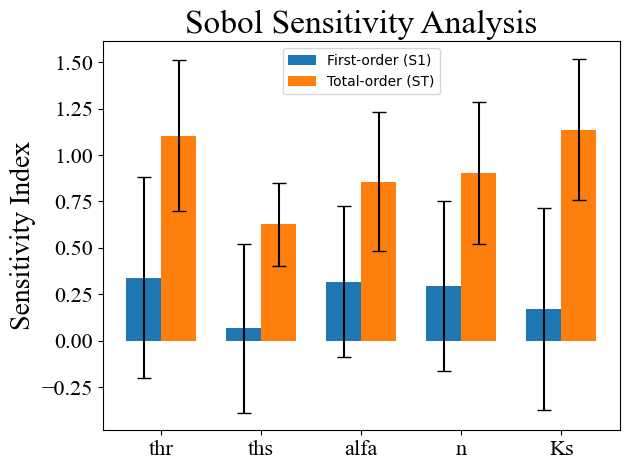

In [ ]:
import matplotlib.pyplot as plt

# Plot Sobol indices
x = np.arange(len(parameter_names))
width = 0.35

plt.bar(x - width/2, S1, width, label='First-order (S1)', yerr=S1_conf, capsize=5)
plt.bar(x + width/2, ST, width, label='Total-order (ST)', yerr=ST_conf, capsize=5)

plt.xticks(x, parameter_names, fontsize=16, fontname='Times New Roman')
plt.yticks(fontsize=16, fontname='Times New Roman')
plt.ylabel('Sensitivity Index', fontsize=20, fontname='Times New Roman')
plt.title('Sobol Sensitivity Analysis', fontsize=24, fontname='Times New Roman')
plt.legend()
plt.tight_layout()
plt.show()


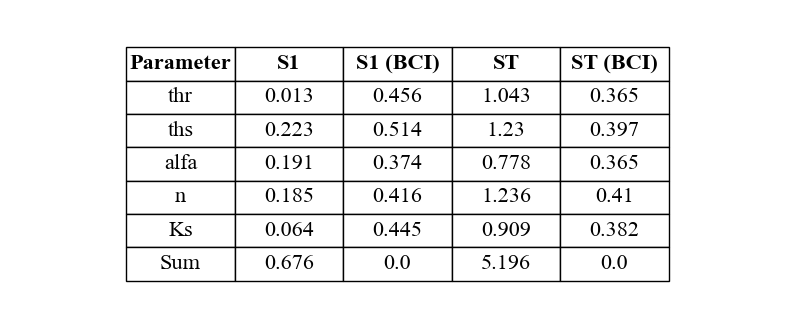

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure sobol_results is defined and clean up the data
table_data = sobol_results.copy()

# Replace empty strings in 'S1 (BCI)' and 'ST (BCI)' with NaN, then fill with 0 and round to 3 decimal places
table_data['S1 (BCI)'] = pd.to_numeric(table_data['S1 (BCI)'], errors='coerce').fillna(0).round(3)
table_data['ST (BCI)'] = pd.to_numeric(table_data['ST (BCI)'], errors='coerce').fillna(0).round(3)

# Round 'S1' and 'ST' columns to 3 decimal places
table_data['S1'] = table_data['S1'].round(3)
table_data['ST'] = table_data['ST'].round(3)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Hide the axes
ax.axis('off')
ax.axis('tight')

# Create a table with the data
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center')

# Set font properties for the table
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(0.7, 2)  # Adjust the scale of the table

# Set font properties for the headers
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_fontsize(16)
        cell.set_text_props(fontname='Times New Roman', weight='bold')
    else:
        cell.set_text_props(fontname='Times New Roman')

# Save the table as an image
plt.savefig('sobol_results_table.png', dpi=300, bbox_inches='tight')
plt.show()


# Response Surface

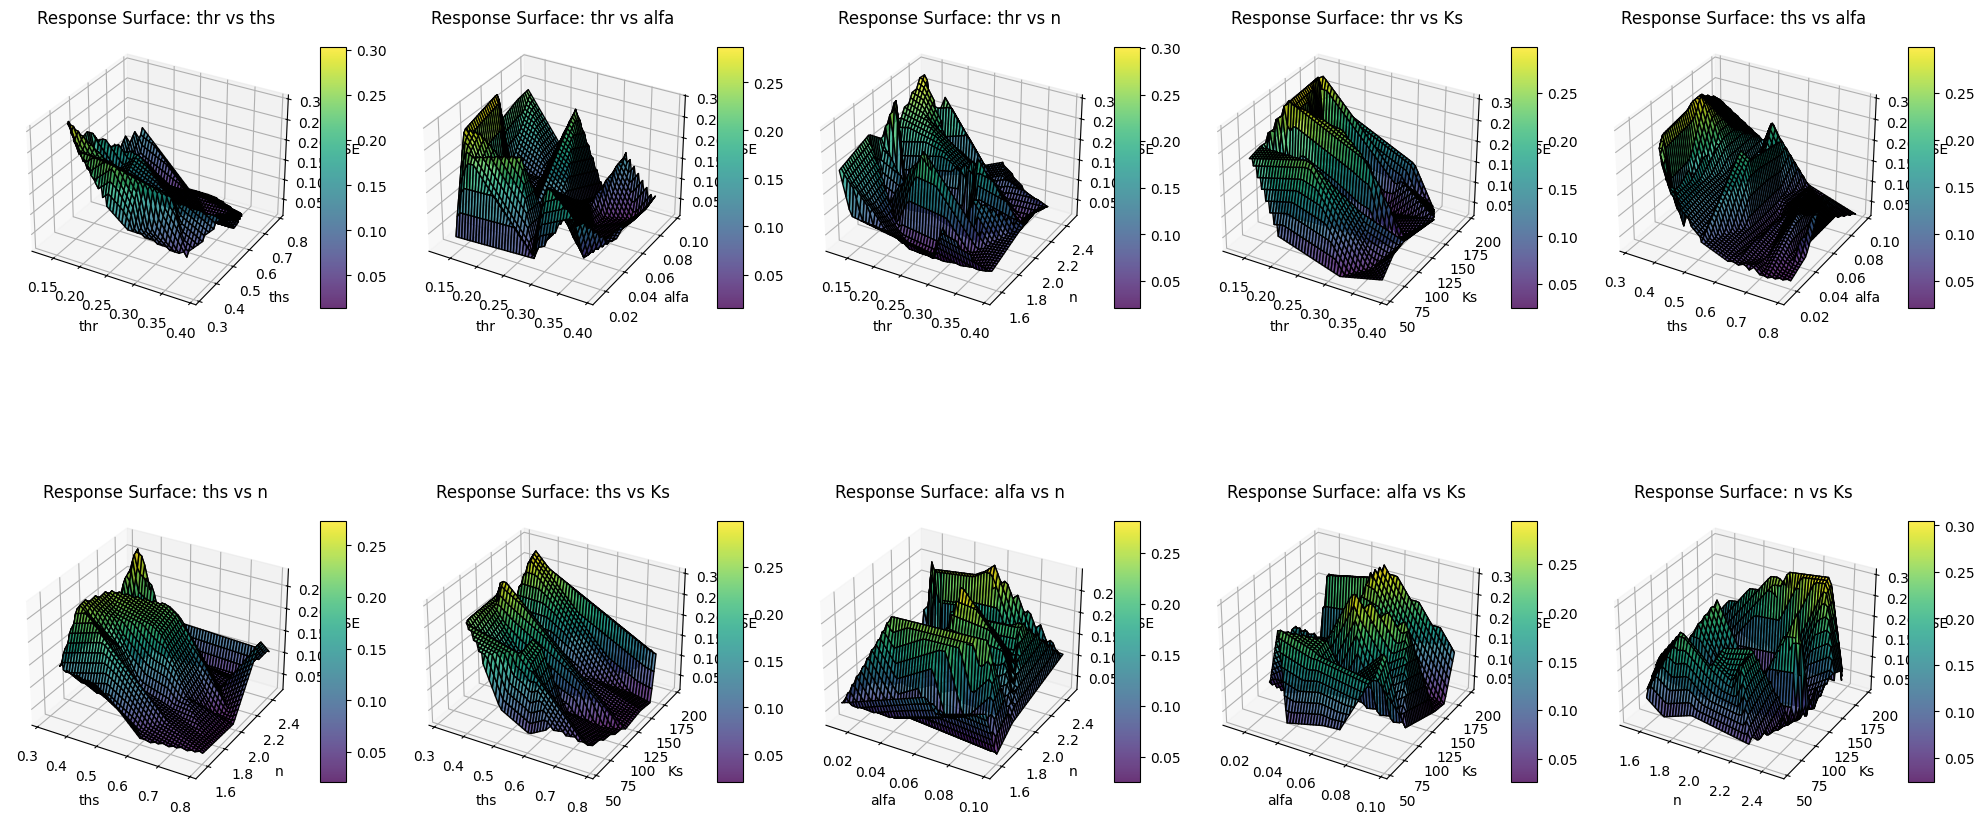

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load simulation results
simulation_results = pd.read_csv('simulation_results_3b.csv')

# Extract parameters and RMSE
parameters = ['thr', 'ths', 'alfa', 'n', 'Ks']
rmse = simulation_results['RMSE']

# Create subplots for all parameter combinations
fig = plt.figure(figsize=(20, 15))
combs = list(combinations(parameters, 2))

for i, (param1, param2) in enumerate(combs, 1):
    # Extract parameter values
    x = simulation_results[param1]
    y = simulation_results[param2]

    # Create a grid for the response surface
    grid_x = np.linspace(x.min(), x.max(), 50)
    grid_y = np.linspace(y.min(), y.max(), 50)
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = griddata((x, y), rmse, (X, Y), method='linear')

    # Create subplot
    ax = fig.add_subplot(3, 5, i, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)
    ax.set_xlabel(param1)
    ax.set_ylabel(param2)
    ax.set_zlabel('RMSE')
    ax.set_title(f'Response Surface: {param1} vs {param2}')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


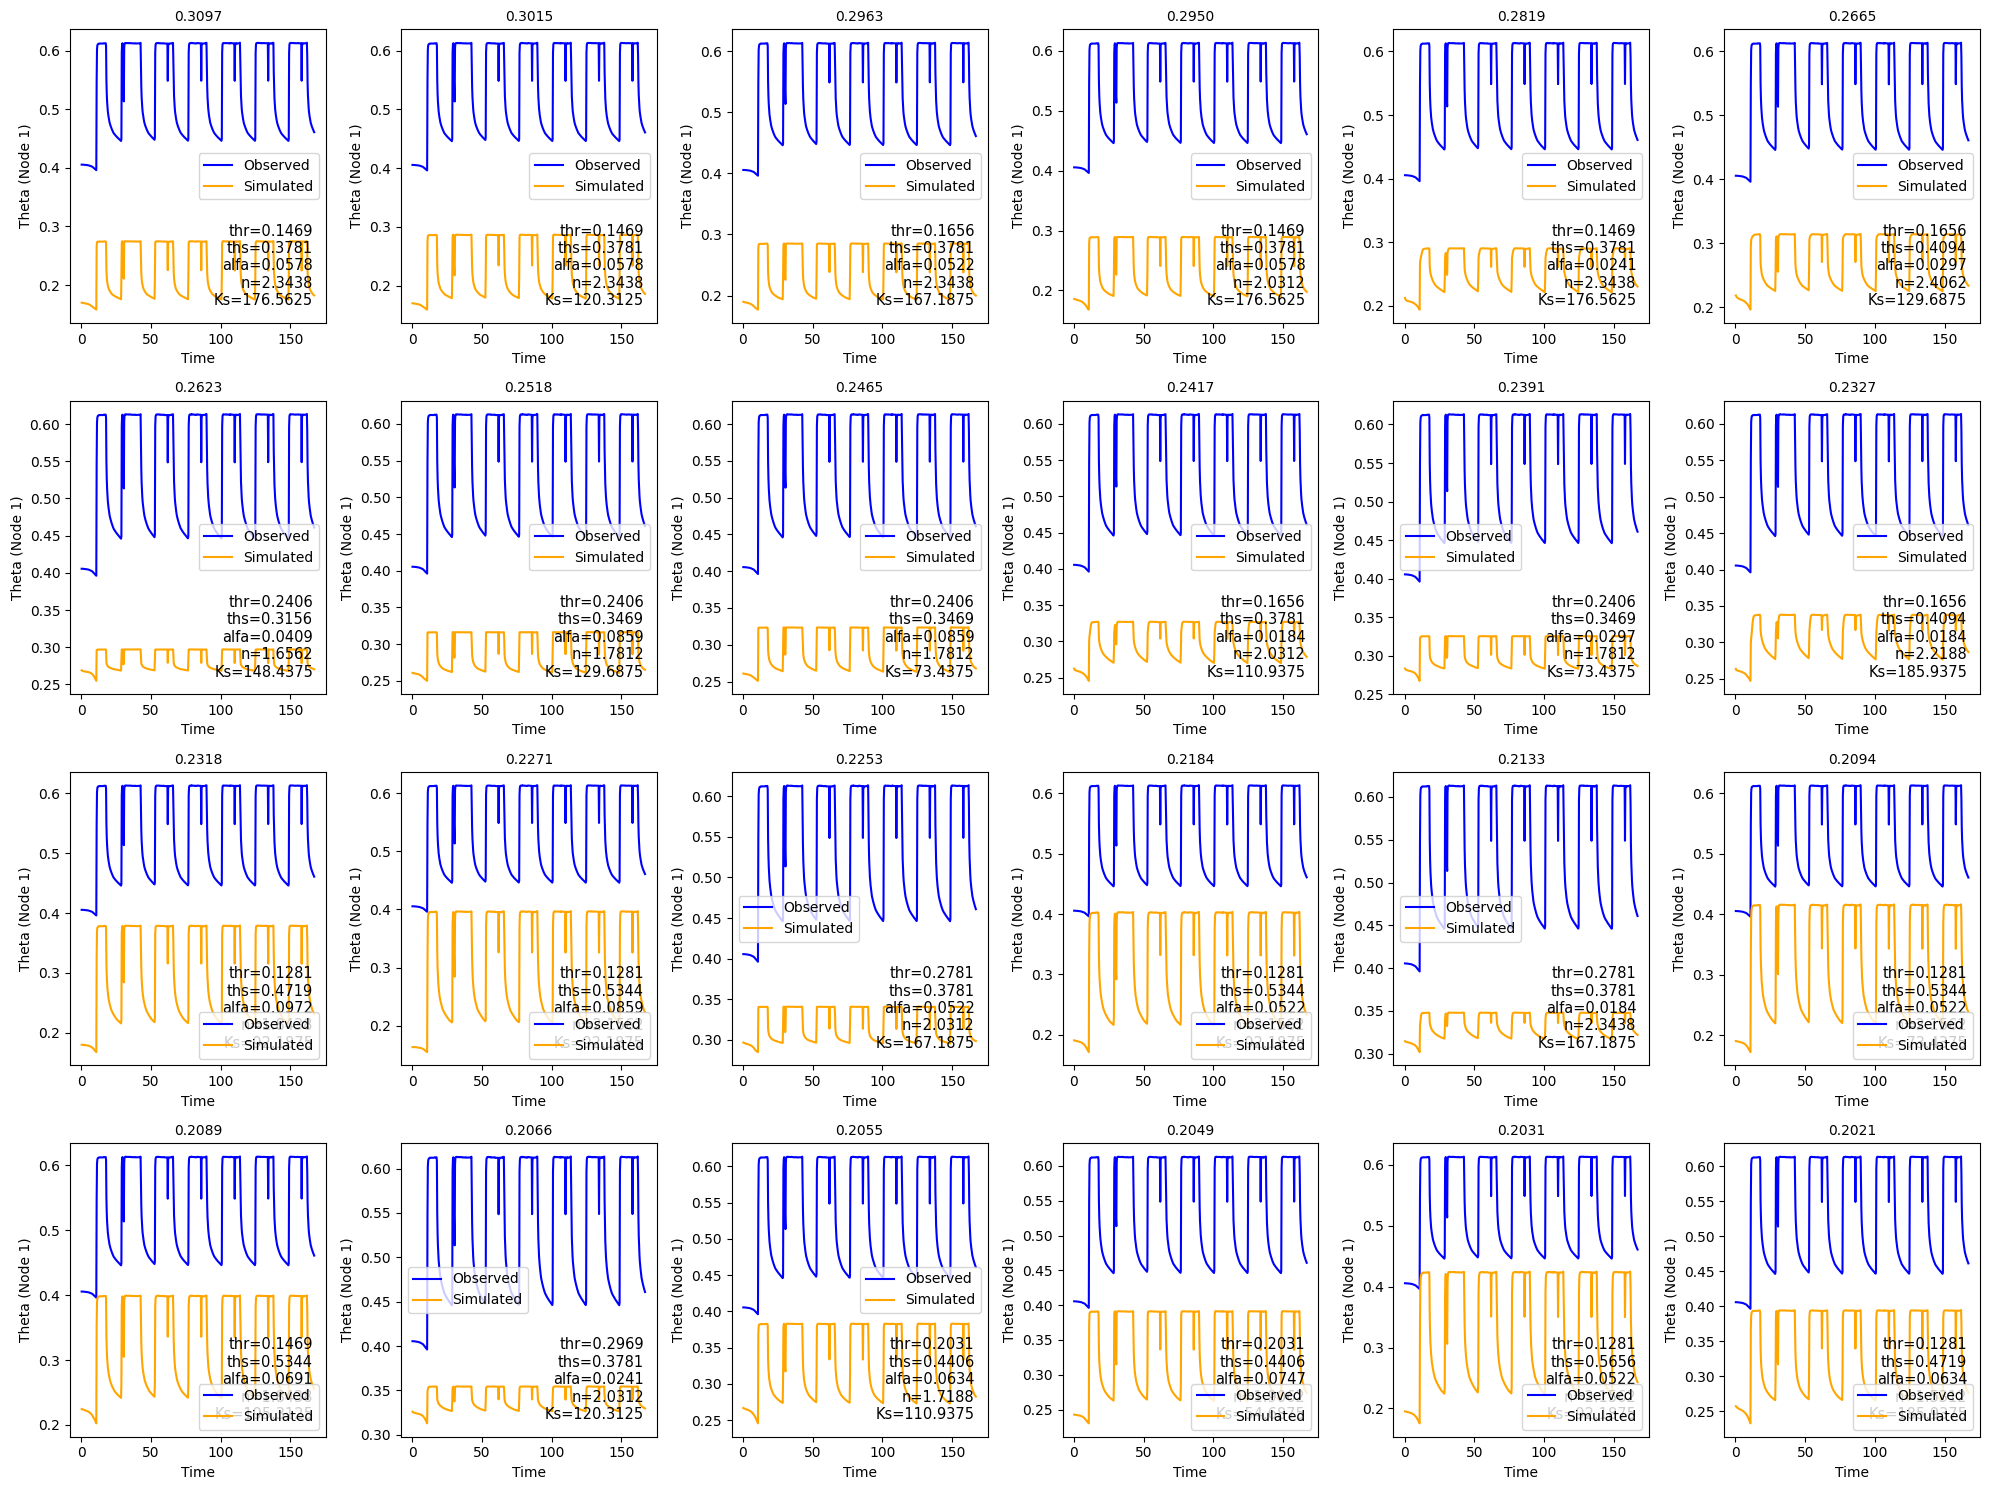

In [ ]:
import matplotlib.pyplot as plt

# Group the simulation results by the parameter set (thr, ths, alfa, n, Ks) and calculate the mean RMSE for each group
grouped = simulation_results.groupby(['thr', 'ths', 'alfa', 'n', 'Ks'])
grouped_rmse = grouped['RMSE'].mean().sort_values(ascending=False)  # Sort by RMSE in descending order

# Create a 4x6 grid for the plots
fig, axes = plt.subplots(4, 6, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot observed and simulated values for each parameter set, sorted by RMSE
for idx, ((thr, ths, alfa, n, Ks), _) in enumerate(grouped_rmse.items()):
    if idx >= len(axes):  # Stop if there are more groups than available subplots
        break
    ax = axes[idx]
    group = grouped.get_group((thr, ths, alfa, n, Ks))
    rmse_value = group['RMSE'].iloc[0]  # Get the RMSE value for the group
    ax.plot(obsnod_synthetic_data['Time'], obsnod_synthetic_data['theta_Node1'], label='Observed', color='blue')
    ax.plot(group['Time'], group['Simulated'], label='Simulated', color='orange')
    ax.set_xlabel('Time')
    ax.set_ylabel('Theta (Node 1)')
    ax.set_title(f'{rmse_value:.4f}', fontsize=10)  # General title as RMSE
    ax.legend()
    
    # Add parameter details beside the scale
    ax.text(0.95, 0.05, f'thr={thr:.4f}\nths={ths:.4f}\nalfa={alfa:.4f}\nn={n:.4f}\nKs={Ks:.4f}', 
            transform=ax.transAxes, fontsize=10.5, verticalalignment='bottom', horizontalalignment='right')
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Hide any unused subplots
for idx in range(len(grouped_rmse), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

final real real

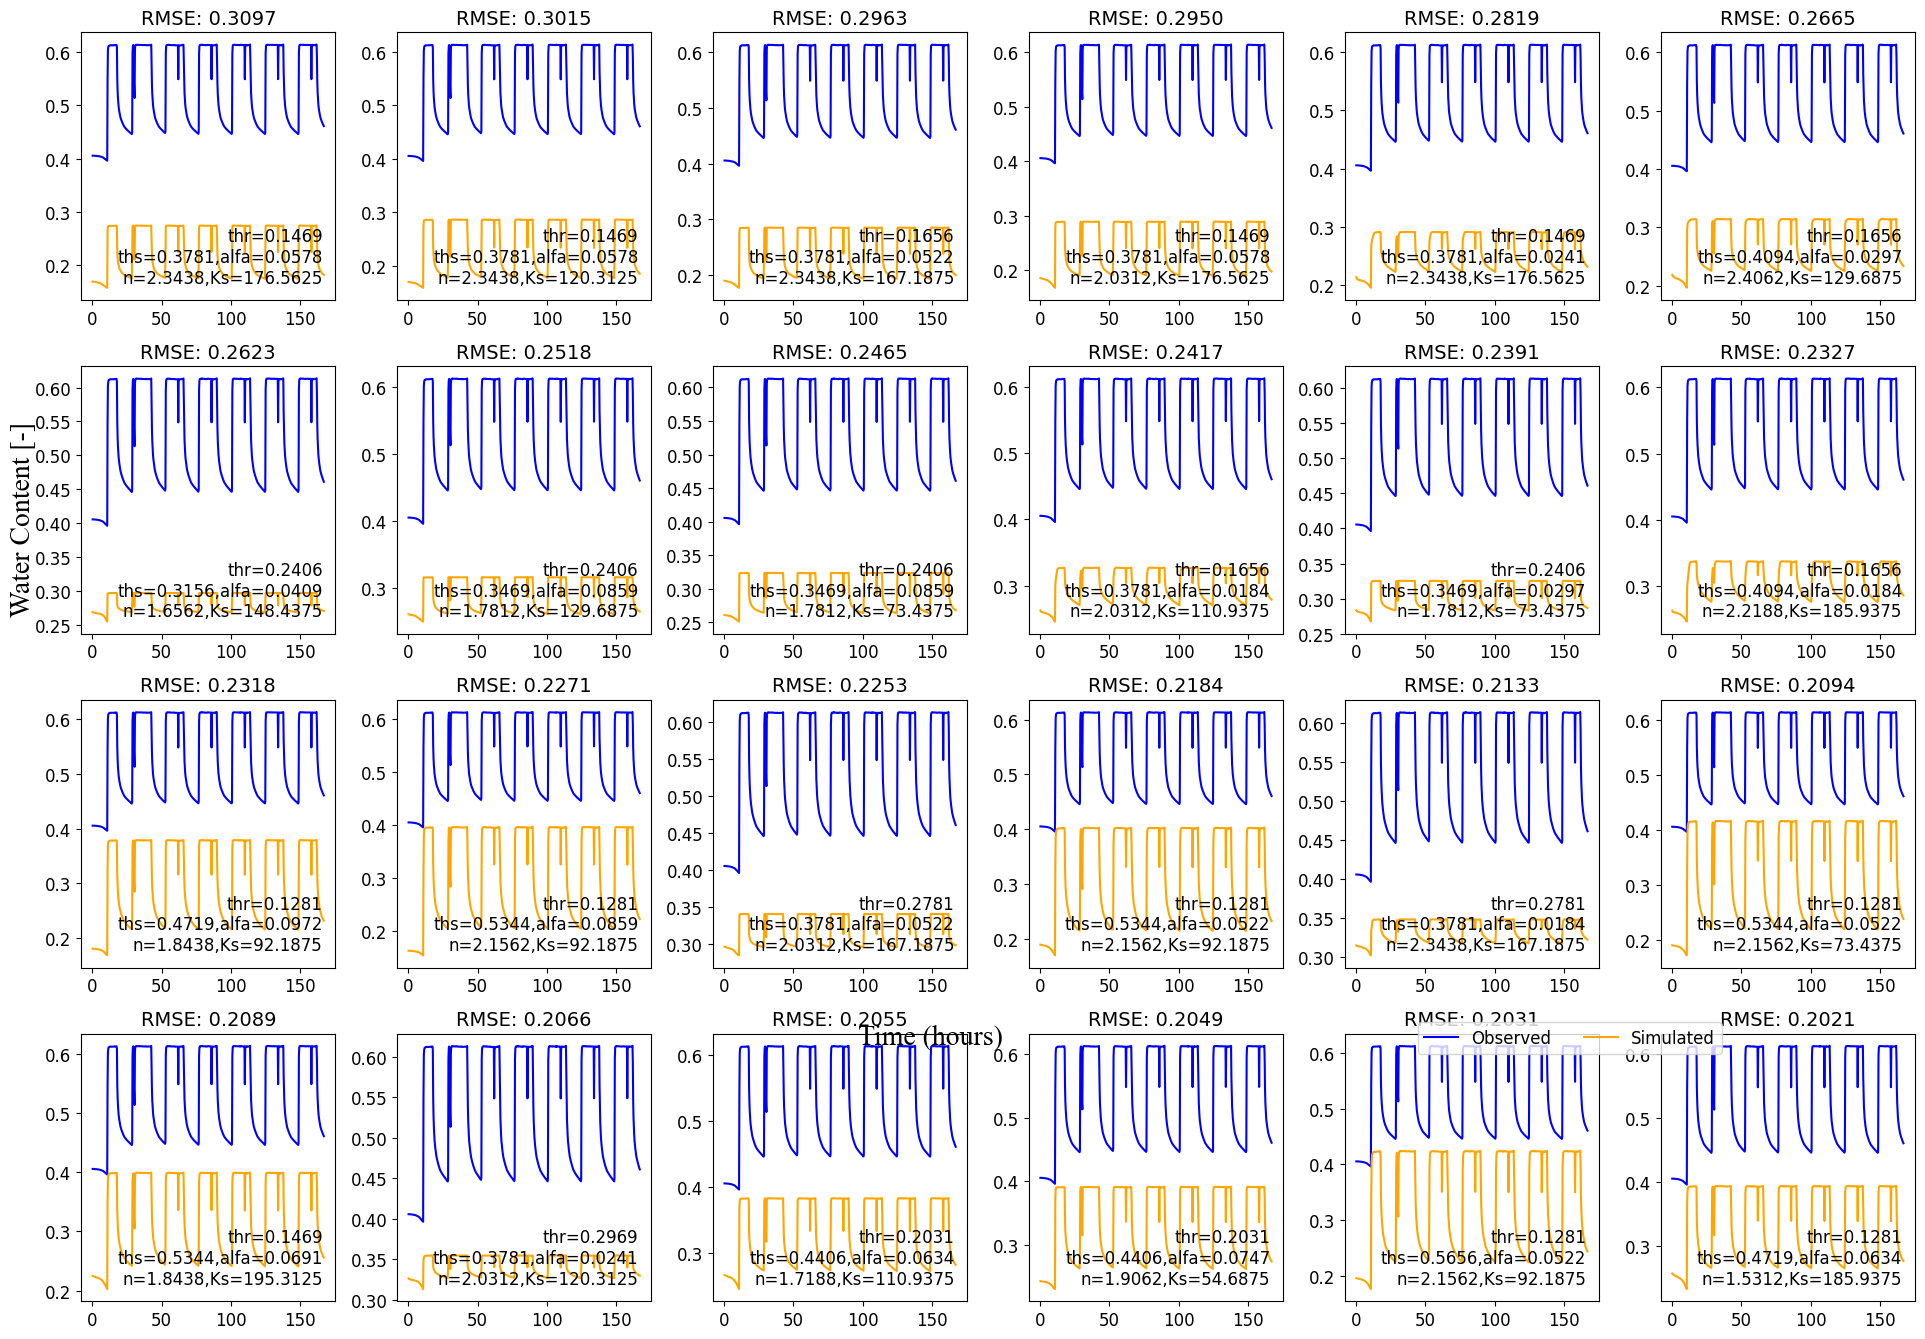

In [ ]:
import matplotlib.pyplot as plt

# Group the simulation results by the parameter set (thr, ths, alfa, n, Ks) and calculate the mean RMSE for each group
grouped = simulation_results.groupby(['thr', 'ths', 'alfa', 'n', 'Ks'])
grouped_rmse = grouped['RMSE'].mean()

# Filter out the specified RMSE values
excluded_rmse_values = [0.1607, 0.1561,  0.1223, 0.1191, 0.1072]
filtered_rmse = grouped_rmse[~grouped_rmse.round(4).isin(excluded_rmse_values)].sort_values(ascending=False)

# Create a 4x6 grid for the plots
fig, axes = plt.subplots(4, 6, figsize=(20, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot observed and simulated values for each parameter set, sorted by RMSE
for idx, ((thr, ths, alfa, n, Ks), _) in enumerate(filtered_rmse.items()):
    if idx >= len(axes):  # Stop if there are more groups than available subplots
        break
    ax = axes[idx]
    group = grouped.get_group((thr, ths, alfa, n, Ks))
    rmse_value = group['RMSE'].iloc[0]  # Get the RMSE value for the group
    ax.plot(obsnod_synthetic_data['Time'], obsnod_synthetic_data['theta_Node1'], label='Observed', color='blue')
    ax.plot(group['Time'], group['Simulated'], label='Simulated', color='orange')
    ax.set_title(f'RMSE: {rmse_value:.4f}', fontsize=14)  # General title as RMSE
    
    # Add parameter details beside the scale
    ax.text(0.95, 0.05, f'thr={thr:.4f}\nths={ths:.4f},alfa={alfa:.4f}\nn={n:.4f},Ks={Ks:.4f}', 
            transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    
    # Increase font size of x and y axis tick labels
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# Add a single legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.27), ncol=6, fontsize=12)

# Hide any unused subplots
for idx in range(len(filtered_rmse), len(axes)):
    fig.delaxes(axes[idx])

# Add general axis labels
fig.text(0.5, 0.25, 'Time (hours)', ha='center', fontsize=20, fontname='Times New Roman')
fig.text(0.04, 0.6, 'Water Content [-]', va='center', rotation='vertical', fontsize=20, fontname='Times New Roman')

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Adjust layout to accommodate axis labels
plt.show()

Optimal Parameters:
thr       0.353125
ths       0.753125
alfa      0.085938
n         2.093750
Ks      129.687500
Name: 31421, dtype: float64
Optimal RMSE: 0.0132


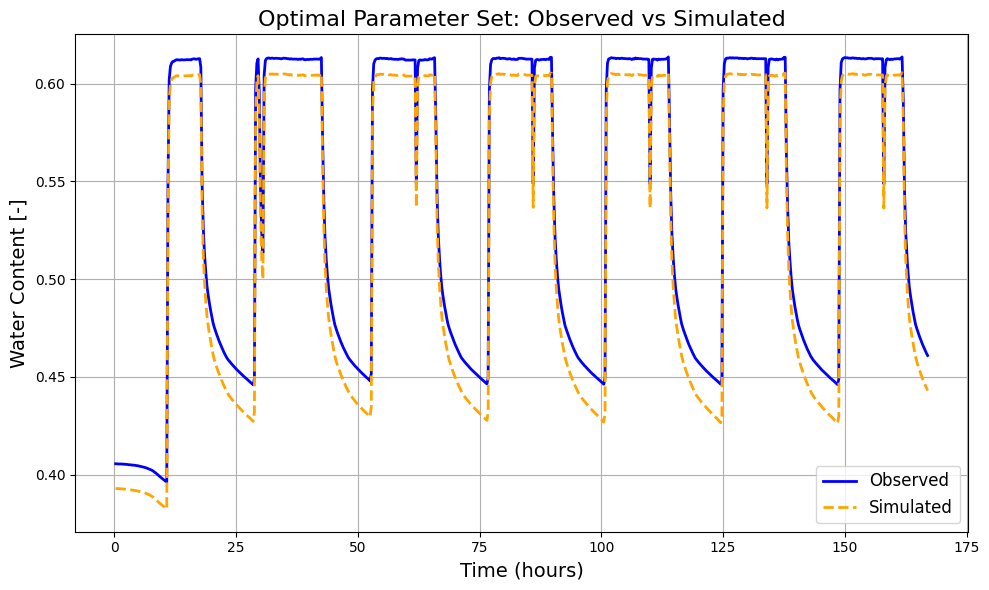

In [ ]:
import matplotlib.pyplot as plt

# Extract the optimal parameter set (minimum RMSE)
optimal_params = simulation_results.loc[simulation_results['RMSE'].idxmin()]
print("Optimal Parameters:")
print(optimal_params[['thr', 'ths', 'alfa', 'n', 'Ks']])
rmse_value = optimal_params['RMSE']
print(f"Optimal RMSE: {rmse_value:.4f}")


# Plot observed vs simulated values for the optimal parameter set
optimal_time = simulation_results[simulation_results['RMSE'] == optimal_params['RMSE']]['Time']
optimal_observed = simulation_results[simulation_results['RMSE'] == optimal_params['RMSE']]['Observed']
optimal_simulated = simulation_results[simulation_results['RMSE'] == optimal_params['RMSE']]['Simulated']

plt.figure(figsize=(10, 6))
plt.plot(optimal_time, optimal_observed, label='Observed', color='blue', linewidth=2)
plt.plot(optimal_time, optimal_simulated, label='Simulated', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('Water Content [-]', fontsize=14)
plt.title('Optimal Parameter Set: Observed vs Simulated', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Parameters with Maximum RMSE:
thr       0.146875
ths       0.378125
alfa      0.057813
n         2.343750
Ks      176.562500
Name: 58263, dtype: float64
Maximum RMSE: 0.3097


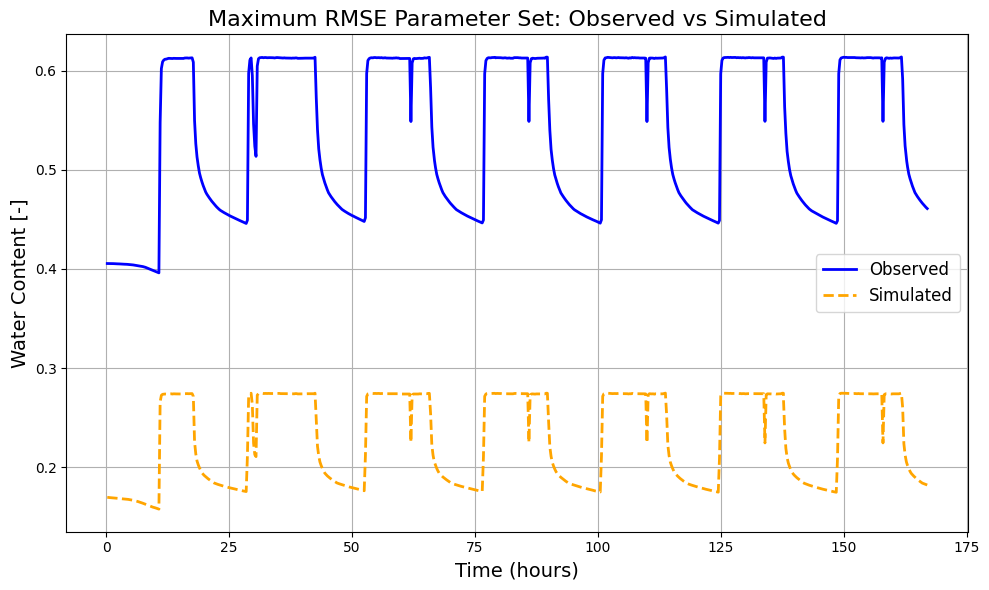

In [ ]:
import matplotlib.pyplot as plt

# Extract the parameter set with the maximum RMSE
max_rmse_params = simulation_results.loc[simulation_results['RMSE'].idxmax()]
print("Parameters with Maximum RMSE:")
print(max_rmse_params[['thr', 'ths', 'alfa', 'n', 'Ks']])
max_rmse_value = max_rmse_params['RMSE']
print(f"Maximum RMSE: {max_rmse_value:.4f}")

# Extract observed and simulated values for the maximum RMSE parameter set
max_rmse_time = simulation_results[simulation_results['RMSE'] == max_rmse_value]['Time']
max_rmse_observed = simulation_results[simulation_results['RMSE'] == max_rmse_value]['Observed']
max_rmse_simulated = simulation_results[simulation_results['RMSE'] == max_rmse_value]['Simulated']

# Plot observed vs simulated values
plt.figure(figsize=(10, 6))
plt.plot(max_rmse_time, max_rmse_observed, label='Observed', color='blue', linewidth=2)
plt.plot(max_rmse_time, max_rmse_simulated, label='Simulated', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Time (hours)', fontsize=14)
plt.ylabel('Water Content [-]', fontsize=14)
plt.title('Maximum RMSE Parameter Set: Observed vs Simulated', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()